# Introduction
Our goal is to measure how much performance gain can be achieved using active learning approach for training simple scikit-learn pipeline in terms of labeling costs and final evaluation metrics.
We will build spam classifier using simple scikit-learn pipeline and compare active learning results with traditional ML approach.

Dataset: https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip

# Imports

In [1]:
# system
import os
import sys

# data and models
import numpy as np
import pandas as pd
import scipy
import random

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score

# visualization
import matplotlib.pyplot as plt
from tqdm import tqdm

# dataset retrieval
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

In [2]:
os.chdir('../')

In [3]:
sys.path.append('.')

In [4]:
# Disable jedi autocompleter
%config Completer.use_jedi = False

# Set random seeds

In [5]:
# Set the random seeds
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
RANDOM_SEED = 42

# Dataset
Let's download dataset from given [url](https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip), then take a look at samples.

## Retrieve dataset

In [6]:
def get_dataset():
    resp = urlopen("https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip")
    zipfile = ZipFile(BytesIO(resp.read()))
    
    lines = list()
    for line in zipfile.open('SMSSpamCollection').readlines():
        lines.append(line.decode('utf-8'))
    
    data = pd.DataFrame(data=lines)
    new = data[0].str.split("\t", n = 1, expand = True) 
    data["text"]= new[1] 
    data["label"]= new[0] 
    data.drop(columns=[0], inplace = True)
    
    return data

In [7]:
dataset = get_dataset()

## Explore Samples

In [8]:
dataset.head()

,text,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...\n,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [9]:
dataset.shape

(5574, 2)

## Generate Train/Test splits and move forward

We see the imbalance in target variable

In [10]:
dataset.label.value_counts()

ham     4827
spam     747
Name: label, dtype: int64

We have duplicated records

In [11]:
dataset.duplicated().sum()

403

remove these duplicates

In [12]:
dataset.drop_duplicates(inplace=True)

In [13]:
dataset.reset_index(drop=True, inplace=True)

split into train/test splits with 20/80 ratio

In [14]:
train, test = train_test_split(dataset, test_size=0.2, random_state=RANDOM_SEED)

Store these sets into dataset directory

In [15]:
DATASET_NAME = "SMSSpamCollection"
if not os.path.exists(f'data/{DATASET_NAME}'):
    os.mkdir(f'data/{DATASET_NAME}')
    
    train.to_csv(f'data/{DATASET_NAME}/train.csv')
    test.to_csv(f'data/{DATASET_NAME}/test.csv')

Load again and continue

In [16]:
train = pd.read_csv(f'data/{DATASET_NAME}/train.csv', index_col=0)
test = pd.read_csv(f'data/{DATASET_NAME}/test.csv', index_col=0)

# Traditional ML Pipeline

Here we train traiditional ML pipeline on entire dataset and test on test set to get evaluation metrics

In [17]:
def evaluate(model, dataset):
    preds = model.predict(dataset.text)
    probas = model.predict_proba(dataset.text)[:, 1]
    
    results = {
        "f1": f1_score(dataset.label, preds, pos_label=model.classes_[-1]),
        "precision": precision_score(dataset.label, preds, pos_label=model.classes_[-1]),
        "recall": recall_score(dataset.label, preds, pos_label=model.classes_[-1]),
        "roc_auc": roc_auc_score(dataset.label, probas, labels=model.classes_)
    }
    
    return results

In [18]:
traditional_classifier = Pipeline( 
    steps=[
        ("tfidf", TfidfVectorizer()),
        ('clf', LogisticRegressionCV(
            cv=10,
            penalty='l2',
            scoring='f1',
            n_jobs=-1,
            refit=True,
            random_state=RANDOM_SEED
        )),
    ])

In [19]:
traditional_classifier.fit(train.text, train.label)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 LogisticRegressionCV(cv=10, n_jobs=-1, random_state=42,
                                      scoring='f1'))])

In [20]:
evaluate(traditional_classifier, test)

{'f1': 0.9438202247191011,
 'precision': 0.9692307692307692,
 'recall': 0.9197080291970803,
 'roc_auc': 0.9896932355762197}

# Active Learning ML Pipeline

Now let's implement exactly the same ML pipeline using Active Learning with different approaches of data sampling

In [21]:
class Sampler:
    def __init__(self):
        pass
    
    def sample(self, *args, **kwargs):
        pass

In [22]:
class RandomSampler(Sampler):
    def sample(self, model, dataset, num_samples):
        if num_samples < dataset.shape[0]:
            return dataset.sample(n=num_samples)
        else:
            return dataset.sample(frac=1.0)

In [23]:
class UncertaintySampler(Sampler):
    def sample(self, model, dataset, num_samples):
        probas = model.predict_proba(dataset.text)
        uncertain_indices = np.argsort(np.abs(probas[:,0] - probas[:, 1]))[:num_samples]
        
        return dataset.iloc[uncertain_indices]

In [24]:
class ActiveLearner:
    def __init__(self, test, train, unlabeled, pipeline, batch_size=100, sampler=None):
        self.test = test.copy(deep=True)
        self.train = train.copy(deep=True)
        self.unlabeled = unlabeled.copy(deep=True)
        self.pipeline = pipeline
        self.batch_size=batch_size
        self.sampler=RandomSampler() if sampler is None else sampler
        self.metrics = []
        
        
        # train pipeline on available training set to have initially trained model
        self.pipeline.fit(self.train.text, self.train.label)
        self.metrics.append(evaluate(self.pipeline, self.test))
        
    def run_active_learning(self, iterations=100):
        
        # iteration loop
        for it in tqdm(range(iterations), total=iterations, leave=True, desc='Iterations'):
            
            # sample from "unlabeled" dataset
            sampled_dataset = self.sampler.sample(model=self.pipeline, dataset=self.unlabeled, num_samples=self.batch_size)
            
            # exclude sampled items from "unlabeled" dataset
            self.unlabeled.drop(sampled_dataset.index, axis=0, inplace=True)
            
            # update train dataset
            self.train = pd.concat([self.train, sampled_dataset], axis=0)
            
            # train pipeline on new train dataset
            self.pipeline.fit(self.train.text, self.train.label)
            self.metrics.append(evaluate(self.pipeline, self.test))

### Create Initial Train set

In [25]:
initial_train = train.sample(frac=0.05)
train.drop(initial_train.index, axis=0, inplace=True)

In [26]:
print(f"expected number of iterations (for batch_size=100) is {train.shape[0] // 100}")

expected number of iterations (for batch_size=100) is 39


### Random Sampler Active Learning Model

In [27]:
random_active_learner = ActiveLearner(
    test=test,
    train=initial_train,
    unlabeled=train,
    pipeline=Pipeline( 
        steps=[
            ("tfidf", TfidfVectorizer()),
            ('clf', LogisticRegressionCV(
                cv=10,
                penalty='l2',
                scoring='f1',
                n_jobs=-1,
                refit=True,
                random_state=RANDOM_SEED
            )),
        ]),
    batch_size=100,
    sampler=RandomSampler(),
)

In [28]:
random_active_learner.run_active_learning(iterations=39)

Iterations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:27<00:00,  1.40it/s]


In [29]:
random_active_learner.metrics[:2]

[{'f1': 0.5876288659793815,
  'precision': 1.0,
  'recall': 0.41605839416058393,
  'roc_auc': 0.9607278136328906},
 {'f1': 0.7373271889400921,
  'precision': 1.0,
  'recall': 0.583941605839416,
  'roc_auc': 0.9701201372067693}]

### Uncertainty Sampler Active Learning Model

In [30]:
uncertainty_active_learner = ActiveLearner(
    test=test,
    train=initial_train,
    unlabeled=train,
    pipeline=Pipeline( 
        steps=[
            ("tfidf", TfidfVectorizer()),
            ('clf', LogisticRegressionCV(
                cv=10,
                penalty='l2',
                scoring='f1',
                n_jobs=-1,
                refit=True,
                random_state=RANDOM_SEED
            )),
        ]),
    batch_size=100,
    sampler=UncertaintySampler(),
)

In [31]:
uncertainty_active_learner.run_active_learning(iterations=39)

Iterations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:31<00:00,  1.23it/s]


In [32]:
uncertainty_active_learner.metrics[:2]

[{'f1': 0.5876288659793815,
  'precision': 1.0,
  'recall': 0.41605839416058393,
  'roc_auc': 0.9607278136328906},
 {'f1': 0.8947368421052632,
  'precision': 0.9224806201550387,
  'recall': 0.8686131386861314,
  'roc_auc': 0.969388584526848}]

# Compare Results

In [48]:
def compare_model_metrics(learners, thresholds):
    # generate dataframes from each metrics and store learner names
    metrics_dfs = []
    learner_names = []
    for learner in learners:
        learner_names.append(learner.sampler.__class__.__name__)
        metrics_dfs.append(pd.DataFrame(learner.metrics))
        
    # collect all unique metrics available from learners
    unique_metrics = metrics_dfs[0].columns
    
    # create subplots
    fig, axes = plt.subplots(
        nrows=len(unique_metrics), 
        ncols=1,
        figsize=(10, 10*len(unique_metrics)),
        sharey=True
    )
    
    # compare learners by each metric in separate plot
    for ax, metric_name in zip(axes, unique_metrics):
        comparison_df = pd.DataFrame(
            {
                learner_name: metrics_df[metric_name].values
                for learner_name, metrics_df in zip(learner_names, metrics_dfs)
            }
        )
        comparison_df.plot(kind='line', ax=ax)
        ax.set_title(f"Metric={metric_name}")
        
        # plot horizontal threshold of "traditional" pipeline
        ax.axhline(y=thresholds[metric_name], color='green', linestyle='-')

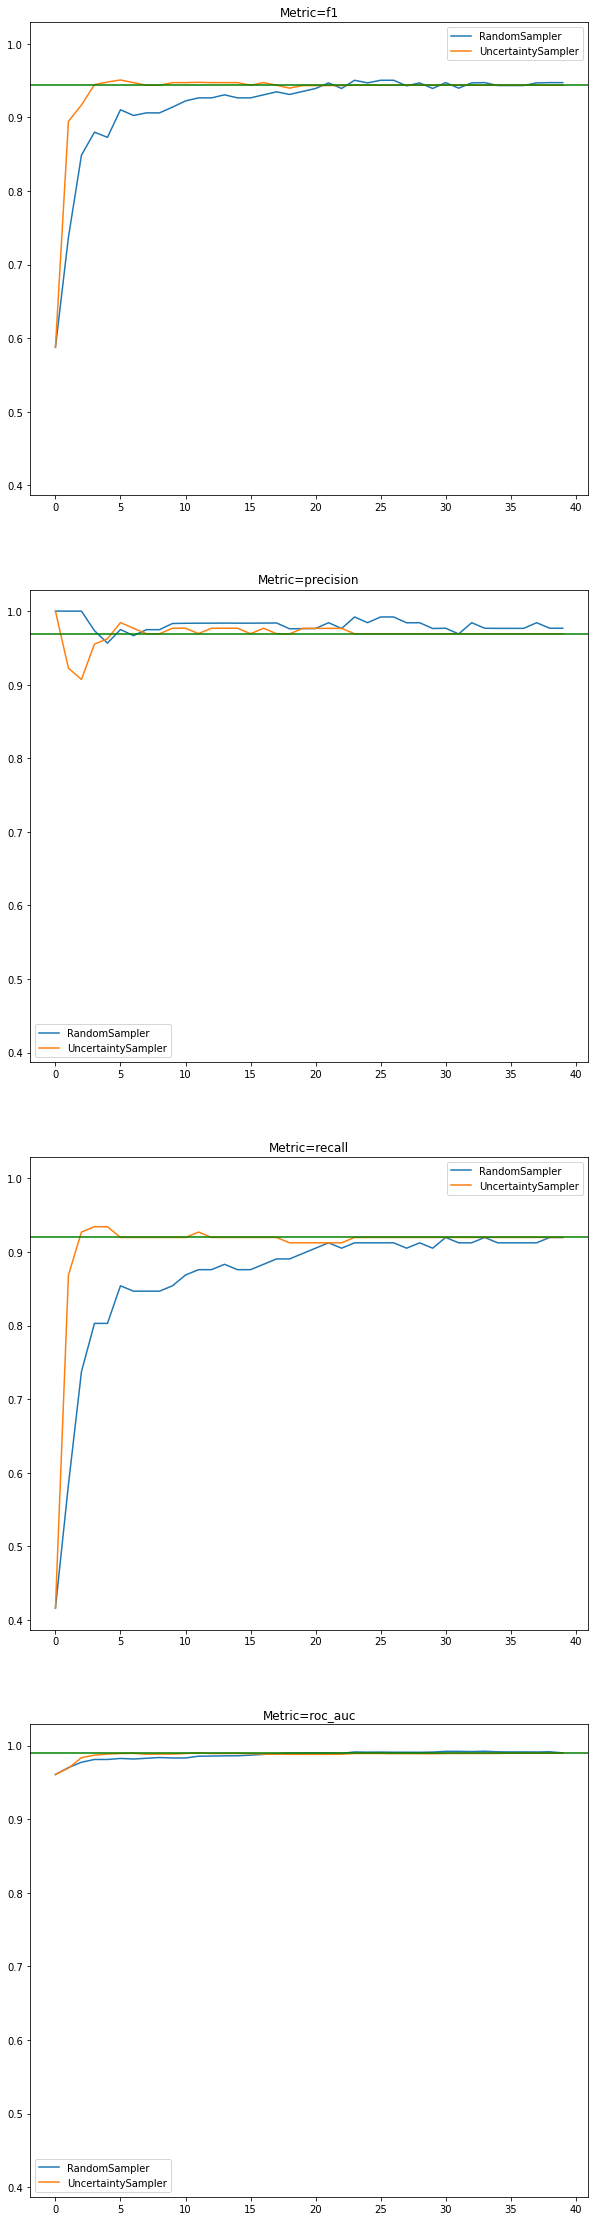

In [49]:
compare_model_metrics(
    learners=[random_active_learner, uncertainty_active_learner], 
    thresholds=evaluate(model=traditional_classifier, dataset=test)
)

# Conclusion

we see that the target metric optimization is achieved much faster with `Uncertainty Sampler`.
It achieved higher performance than `traditional pipeline` in 3-4 iterations (with only 200 + 4*100 = 600 samples)  where `Random Sampler` achieved the same result in 23 iterations (with 200 + 23*100 = 2500 samples). The traditional pipeline used all 4136 samples.

Shortly, `Uncertainty Sampler` achieved the same result in 4136 / 600 = 6.8933 times less data where `Random Sampler` did it in 4136 / 2500 = 1.6544 times less data.